# Cancer-Regression-Analysis

# Imports

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.pipeline import Pipeline as sklearn_pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score,explained_variance_score
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

# Functions

In [51]:
def check_nulls_dupes(df):
  print(f"Number of Nulls: {df.isna().sum()}")
  print(f"Number of Duplicates: {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()
  
def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(20,20))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,4, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def histogram(df, interested_columns, target):
  
  plt.figure(figsize=(20,20))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    ax = plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=False, ax=ax, stat='density', bins=20, color='blue', label=f'Data Histogram for {col}')
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(df[col]), np.std(df[col]))
    ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
    
    title = f"{col.split()[0]}: mu = {np.mean(df[col]):.2f}, std = {np.std(df[col]):.2f}"
    ax.set_title(title)
    ax.legend()
  plt.tight_layout()
  plt.show()


def create_sklearn_pipeline( model, kbest=None):
  
  steps = [
    ("scaler", StandardScaler()),
    ("PowerTransformer", PowerTransformer()),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearn_pipeline(steps=steps)

def pca_analysis(X):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(12, 8))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  return performance_df

def get_selected_models(names):
  models = {
        "SVR": SVR(),
        "LR": LinearRegression(),
        "KNN": KNeighborsRegressor(),
        "GBR": GradientBoostingRegressor(),
        "RFR": RandomForestRegressor(),
        "XGB": XGBRegressor(),
        "LASSO": Lasso(),
        "RIDGE": Ridge(),
        "DUMMY": DummyRegressor(strategy="mean")
    }
    
  return [models[model] for model in names]

def get_metrics(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)
    exp = explained_variance_score(y, predictions)
    
    return [mae, mse, rmse, r2, exp]

def evaluate_model(model, X, y, metric):
    cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
    preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
    mae, mse, rmse, r2, exp = get_metrics(y, preds)
    
    return [
        round(np.mean(scores), 3), 
        round(np.var(scores), 3), 
        round(np.std(scores), 3), 
        round(mae, 3), 
        round(mse, 3),
        round(np.sqrt(rmse), 3),
        round(r2, 3),
        round(exp, 3)
    ]

def test_selected_models(model_names, models, X, y, scoring_metric, kbest=None):
    metric_tracker = []
    
    for model, model_name in zip(models, model_names):
        pipeline = create_sklearn_pipeline( model, kbest) if kbest else create_sklearn_pipeline(model) 
        scores = evaluate_model(pipeline, X, y, scoring_metric)
        metric_tracker.append({
            "Model": model_name,
            "Mean": scores[0],
            "Var": scores[1],
            "STD": scores[2],
            "MAE": scores[3],
            "MSE": scores[4],
            "RMSE": scores[5],
            "R2": scores[6],
            "Explained Var": scores[7]
        })
    
    return pd.DataFrame(metric_tracker).sort_values(by="RMSE", ascending=True)

def test_kbest_columns(X, y, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sklearn_pipeline(model, metric)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae, mse, rmse, r2, exp = get_metrics(y_test, y_pred)

    metric_tracker.append({
            "Model": model_name,
            'K':k,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
            "Explained Var": exp
        })
    
  return pd.DataFrame(metric_tracker)

def optimization_search(model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  metric_tracker = []
  
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sklearn_pipeline(model, kbest)

    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=10, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    mae, mse, rmse, r2, exp = get_metrics(y_test, y_pred)
      
    print(f"The Best Param: {best_params} for Model: {model_name}")
    metric_tracker.append({
            "Model": model_name,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
            "Explained Var": exp
        })
  
  return pd.DataFrame(metric_tracker).sort_values(by="RMSE", ascending=True)

def residual_plot(models, model_names, kbest, X, y):
  
  
  for model, model_name in zip(models, model_names):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    pipeline = create_sklearn_pipeline(model, kbest)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    residuals = y_test - predictions

    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.title(f'Residual Plot for {model_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.grid(True)
    plt.show()
    
    plt.scatter(y_test, predictions)
    plt.show()

def get_feature_names(column_transformer):
    """Get feature names from all transformers in ColumnTransformer."""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'named_steps'): 
                if 'Encoder' in pipe.named_steps: 
                    feature_names = pipe.named_steps['Encoder'].get_feature_names_out(features)
                    output_features.extend(feature_names)
                else:
                    output_features.extend(features)
            else:
                output_features.extend(features)
        else:
            output_features.extend(features)
    return output_features

# EDA Analysis

In [54]:
df1 = pd.read_csv("/Users/maukanmir/Downloads/archive/cancer_reg.csv")
df2 = pd.read_csv("/Users/maukanmir/Downloads/archive/avg-household-size.csv")
df = df1.merge(df2)

# Check For Nulls And Dupes

In [55]:
check_nulls_dupes(df)

Number of Nulls: avganncount                   0
avgdeathsperyear              0
target_deathrate              0
incidencerate                 0
medincome                     0
popest2015                    0
povertypercent                0
studypercap                   0
binnedinc                     0
medianage                     0
medianagemale                 0
medianagefemale               0
geography                     0
percentmarried                0
pctnohs18_24                  0
pcths18_24                    0
pctsomecol18_24            2285
pctbachdeg18_24               0
pcths25_over                  0
pctbachdeg25_over             0
pctemployed16_over          152
pctunemployed16_over          0
pctprivatecoverage            0
pctprivatecoveragealone     609
pctempprivcoverage            0
pctpubliccoverage             0
pctpubliccoveragealone        0
pctwhite                      0
pctblack                      0
pctasian                      0
pctotherrace           

In [59]:
df.dtypes

avganncount                float64
avgdeathsperyear             int64
target_deathrate           float64
incidencerate              float64
medincome                    int64
popest2015                   int64
povertypercent             float64
studypercap                float64
binnedinc                   object
medianage                  float64
medianagemale              float64
medianagefemale            float64
geography                   object
percentmarried             float64
pctnohs18_24               float64
pcths18_24                 float64
pctsomecol18_24            float64
pctbachdeg18_24            float64
pcths25_over               float64
pctbachdeg25_over          float64
pctemployed16_over         float64
pctunemployed16_over       float64
pctprivatecoverage         float64
pctprivatecoveragealone    float64
pctempprivcoverage         float64
pctpubliccoverage          float64
pctpubliccoveragealone     float64
pctwhite                   float64
pctblack            

In [22]:
df.describe()

avganncount  avgdeathsperyear  target_deathrate  incidencerate  \
count   3047.000000       3047.000000       3047.000000    3047.000000   
mean     606.338544        185.965868        178.664063     448.268586   
std     1416.356223        504.134286         27.751511      54.560733   
min        6.000000          3.000000         59.700000     201.300000   
25%       76.000000         28.000000        161.200000     420.300000   
50%      171.000000         61.000000        178.100000     453.549422   
75%      518.000000        149.000000        195.200000     480.850000   
max    38150.000000      14010.000000        362.800000    1206.900000   

           medincome    popest2015  povertypercent  studypercap     binnedinc  \
count    3047.000000  3.047000e+03     3047.000000  3047.000000   3047.000000   
mean    47063.281917  1.026374e+05       16.878175   155.399415  48878.118280   
std     12040.090836  3.290592e+05        6.409087   529.628366  16889.719362   
min     22640.000000  8.270000e+02        3.200000     0.000000  28429.050000   
25%     38882.500000  1.168400e+04       12.150000     0.000000  38888.250000   
50%     45207.000000  2.664300e+04       15.900000     0.000000  46611.300000   
75%     52492.000000  6.867100e+04       20.400000    83.650776  52796.000000   
max    125635.000000  1.017029e+07       47.400000  9762.308998  93564.750000   

         medianage  ...  pctprivatecoveragealone  pctempprivcoverage  \
count  3047.000000  ...              2438.000000         3047.000000   
mean     45.272333  ...                48.453774           41.196324   
std      45.304480  ...                10.083006            9.447687   
min      22.300000  ...                15.700000           13.500000   
25%      37.700000  ...                41.000000           34.500000   
50%      41.000000  ...                48.700000           41.100000   
75%      44.000000  ...                55.600000           47.700000   
max     624.000000  ...                78.900000           70.700000   

       pctpubliccoverage  pctpubliccoveragealone     pctwhite     pctblack  \
count        3047.000000             3047.000000  3047.000000  3047.000000   
mean           36.252642               19.240072    83.645286     9.107978   
std             7.841741                6.113041    16.380025    14.534538   
min            11.200000                2.600000    10.199155     0.000000   
25%            30.900000               14.850000    77.296180     0.620675   
50%            36.300000               18.800000    90.059774     2.247576   
75%            41.550000               23.100000    95.451693    10.509732   
max            65.100000               46.600000   100.000000    85.947799   

          pctasian  pctotherrace  pctmarriedhouseholds    birthrate  
count  3047.000000   3047.000000           3047.000000  3047.000000  
mean      1.253965      1.983523             51.243872     5.640306  
std       2.610276      3.517710              6.572814     1.985816  
min       0.000000      0.000000             22.992490     0.000000  
25%       0.254199      0.295172             47.763063     4.521419  
50%       0.549812      0.826185             51.669941     5.381478  
75%       1.221037      2.177960             55.395132     6.493677  
max      42.619425     41.930251             78.075397    21.326165  

[8 rows x 32 columns]

In [60]:
df.drop("geography", axis=1, inplace=True)

In [7]:
missing_columns = [
  'pctsomecol18_24', # Mean
  'pctemployed16_over', # Mean
  'pctprivatecoveragealone' # # Mean
]

In [61]:
for col in missing_columns:
  df[col] = df[col].fillna(df[col].mean())

In [62]:
categorical_types = df.select_dtypes(include="object")

for col in categorical_types:
  print(categorical_types[col].value_counts())

(54545.6, 61494.5]    306
[22640, 34218.1]      306
(45201, 48021.6]      306
(48021.6, 51046.4]    305
(42724.4, 45201]      305
(51046.4, 54545.6]    305
(37413.8, 40362.7]    304
(40362.7, 42724.4]    304
(34218.1, 37413.8]    304
(61494.5, 125635]     302
Name: binnedinc, dtype: int64


In [63]:
def binned_income(val):
  
  val = re.sub(r'[^\d.,]', '', val)
  val_1, val_2 = val.split(",")
  return (float(val_1) + float(val_2)) / 2

df['binnedinc'] = df["binnedinc"].apply(binned_income)

In [64]:
df.dtypes

avganncount                float64
avgdeathsperyear             int64
target_deathrate           float64
incidencerate              float64
medincome                    int64
popest2015                   int64
povertypercent             float64
studypercap                float64
binnedinc                  float64
medianage                  float64
medianagemale              float64
medianagefemale            float64
percentmarried             float64
pctnohs18_24               float64
pcths18_24                 float64
pctsomecol18_24            float64
pctbachdeg18_24            float64
pcths25_over               float64
pctbachdeg25_over          float64
pctemployed16_over         float64
pctunemployed16_over       float64
pctprivatecoverage         float64
pctprivatecoveragealone    float64
pctempprivcoverage         float64
pctpubliccoverage          float64
pctpubliccoveragealone     float64
pctwhite                   float64
pctblack                   float64
pctasian            

# Visuals

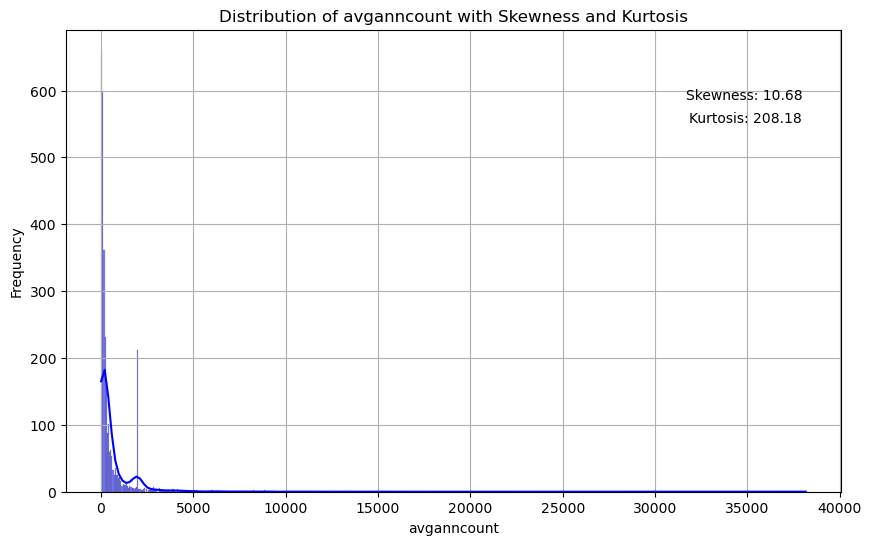

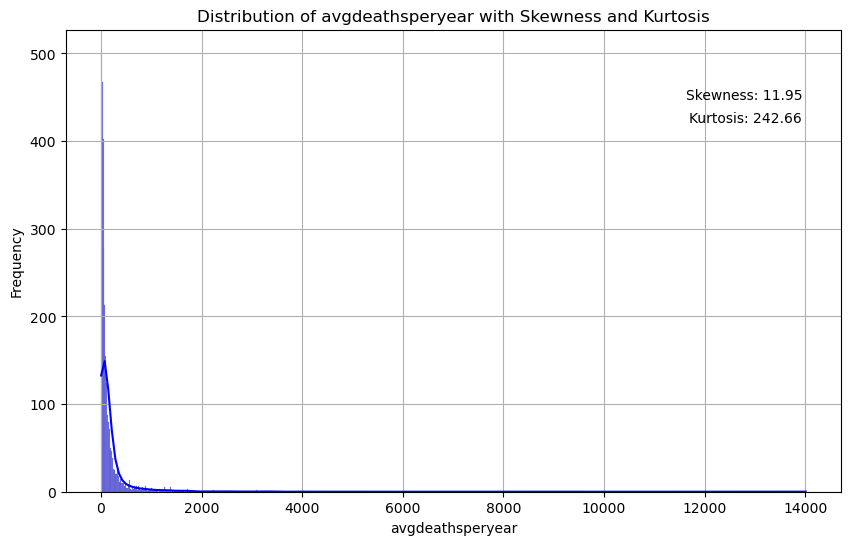

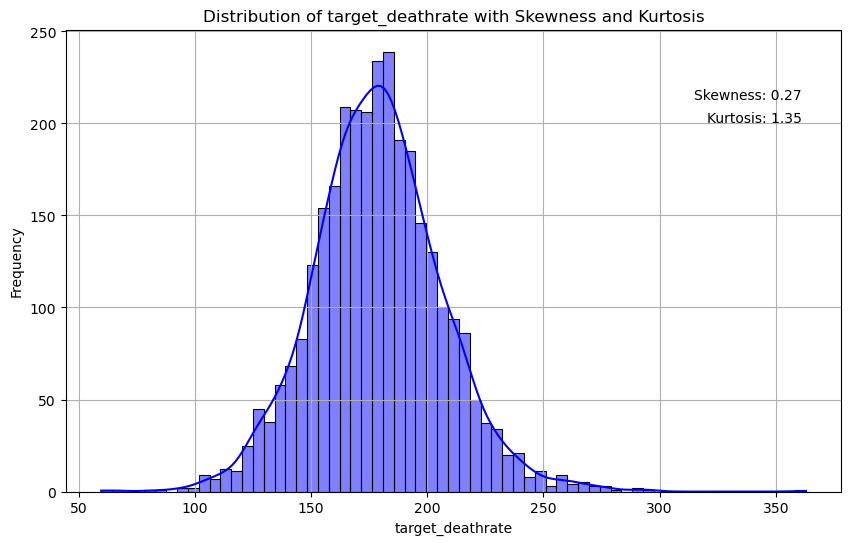

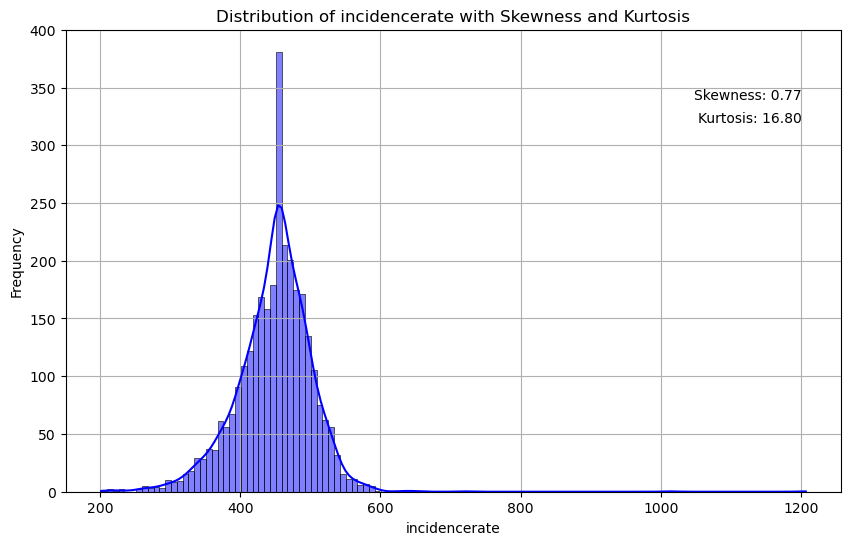

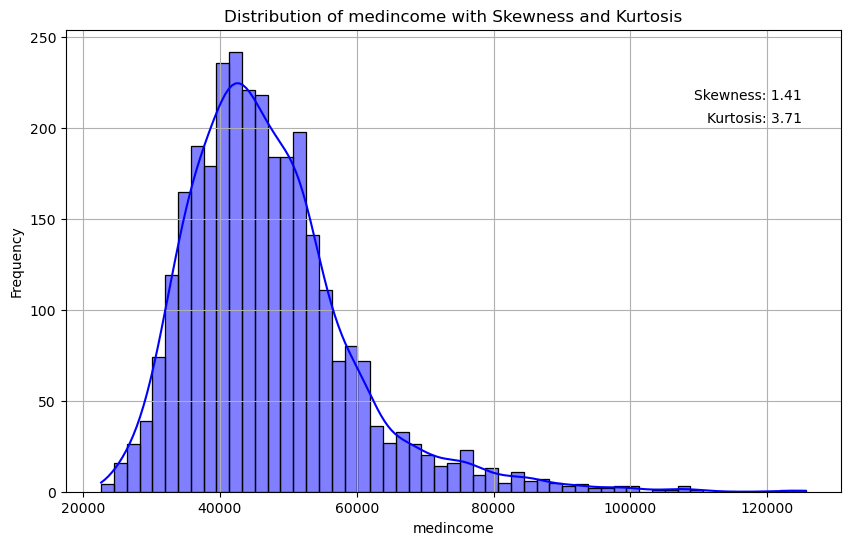

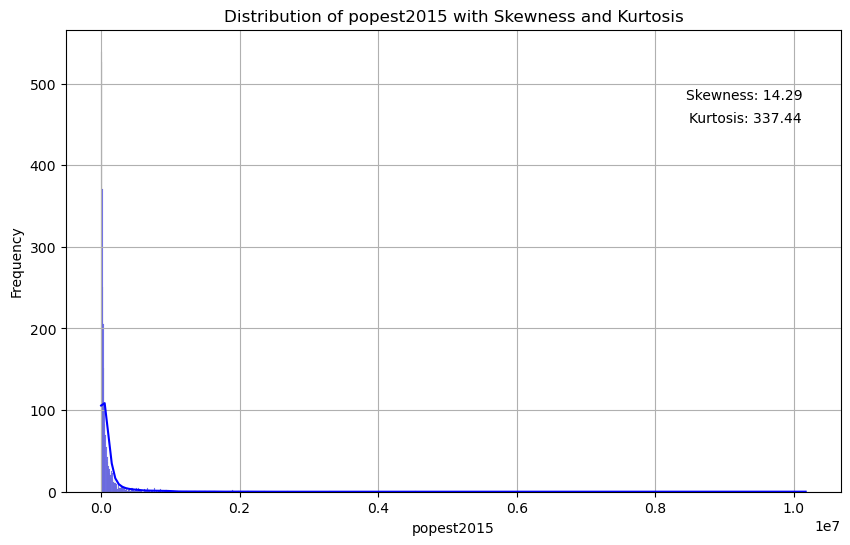

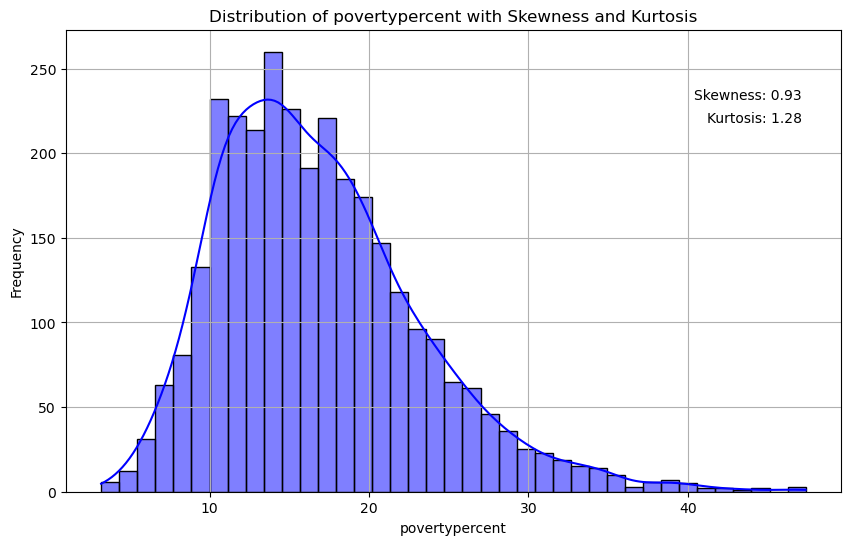

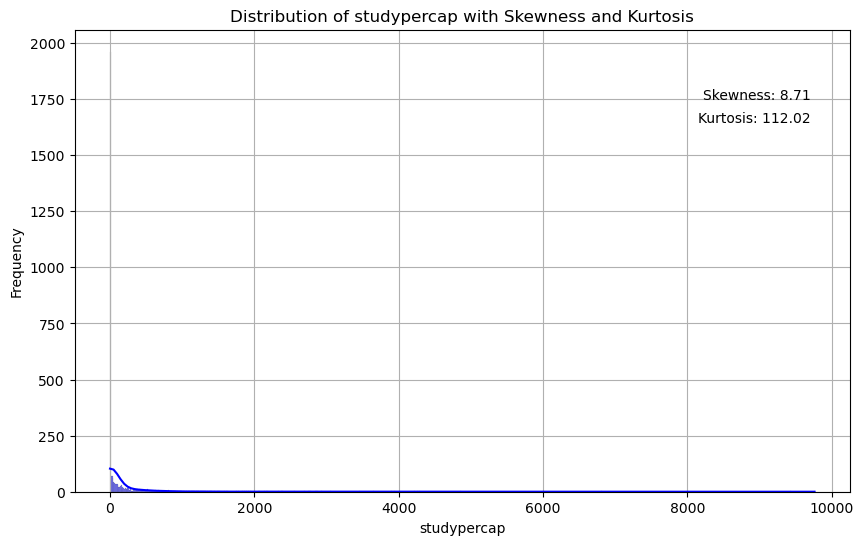

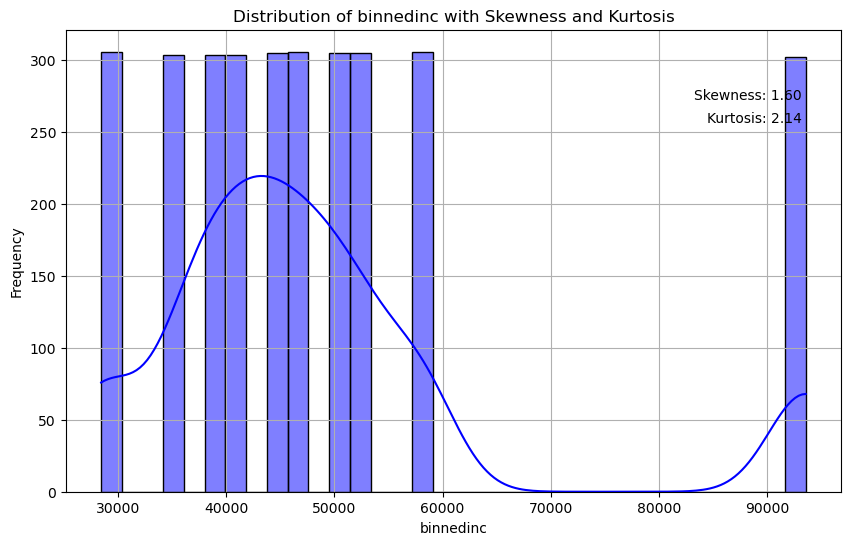

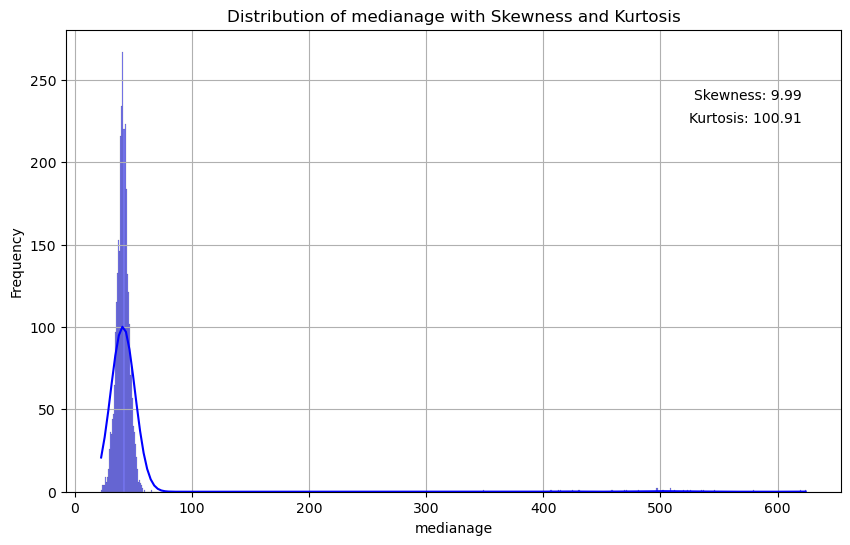

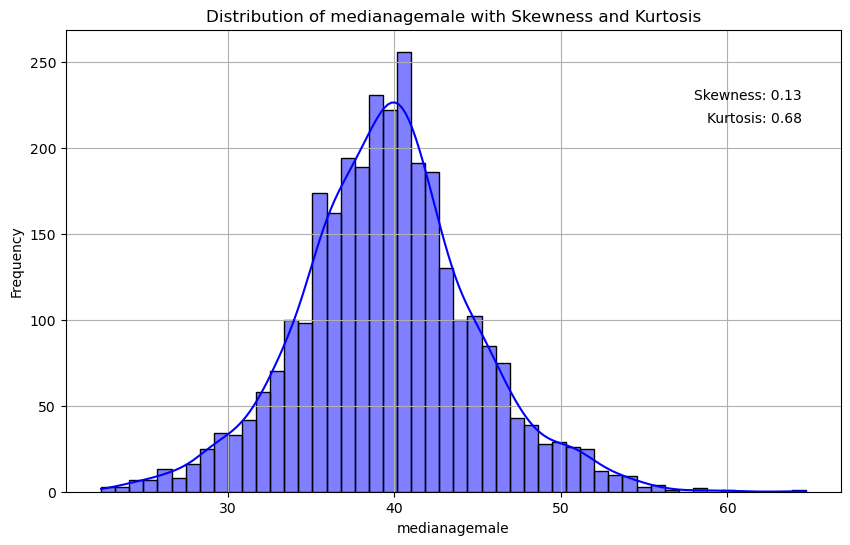

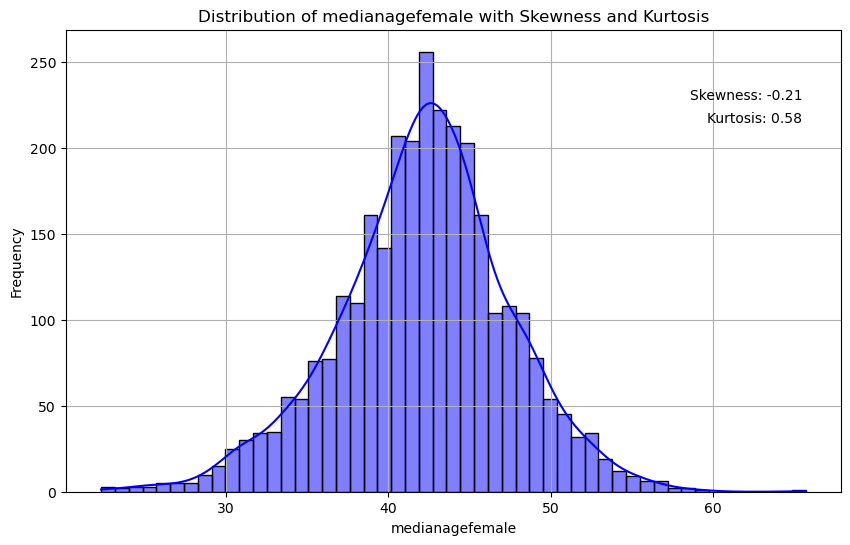

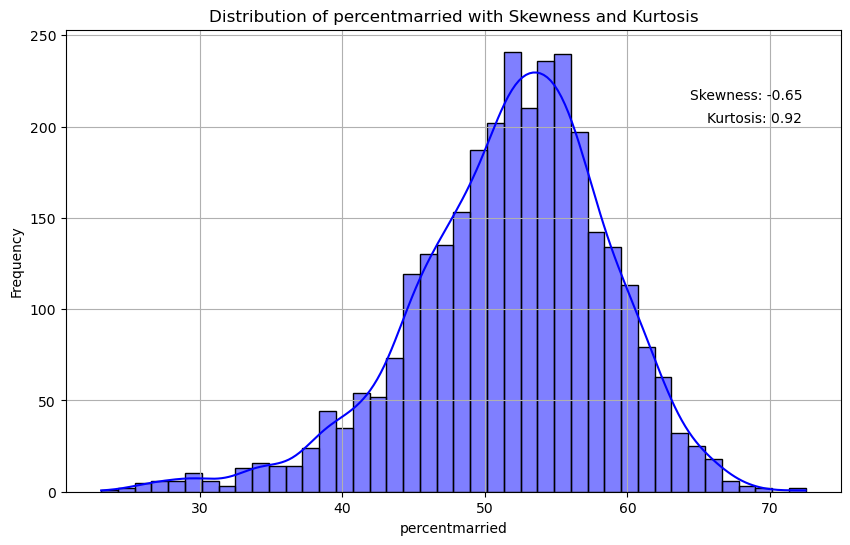

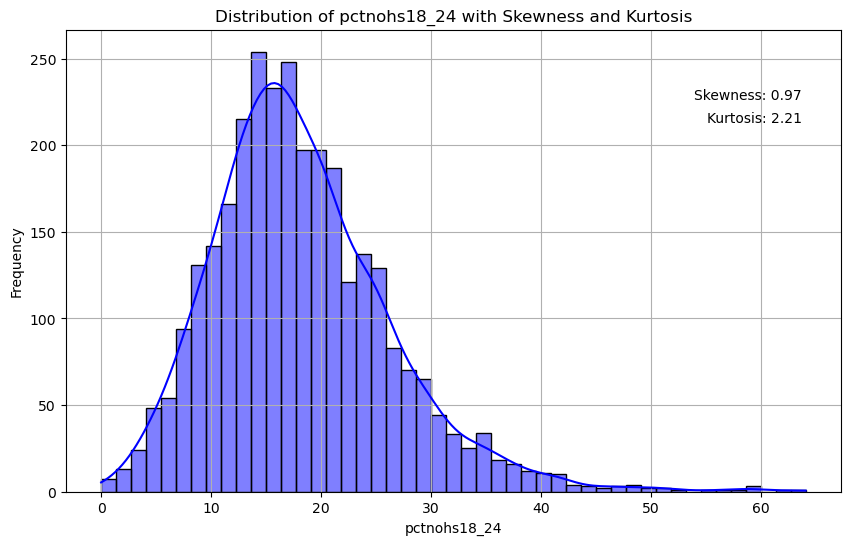

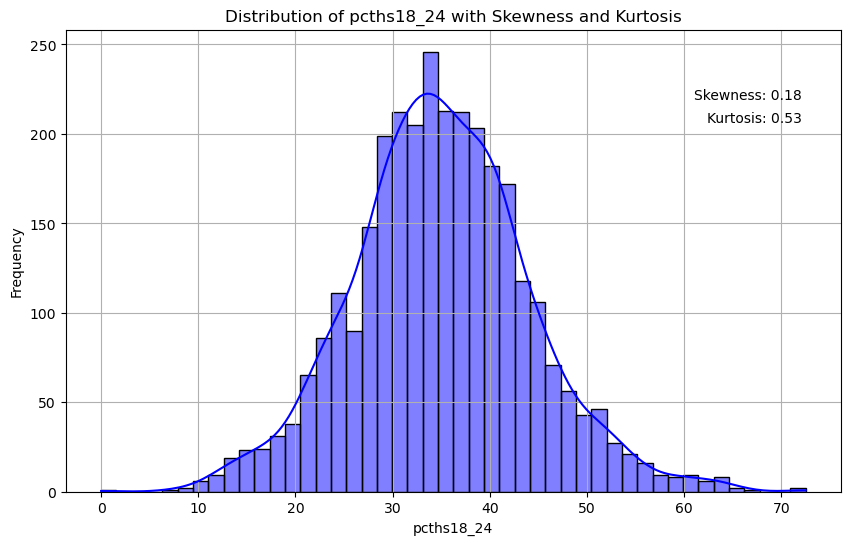

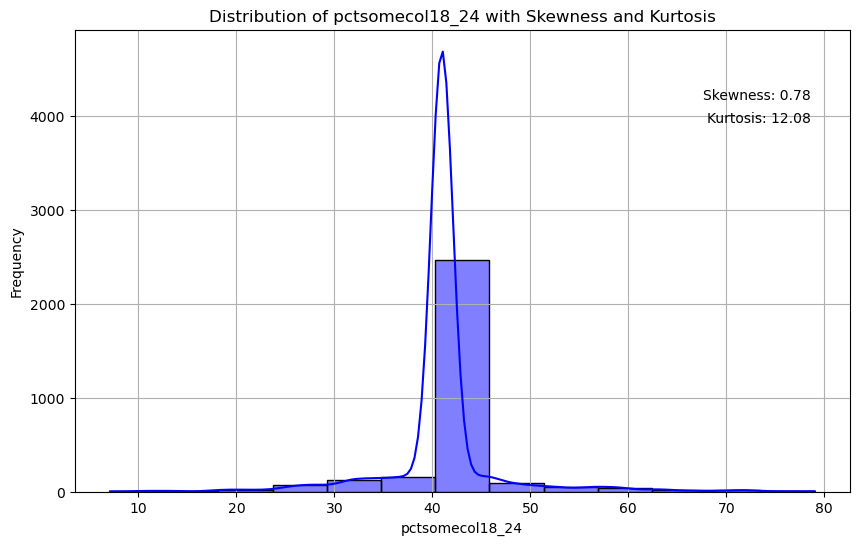

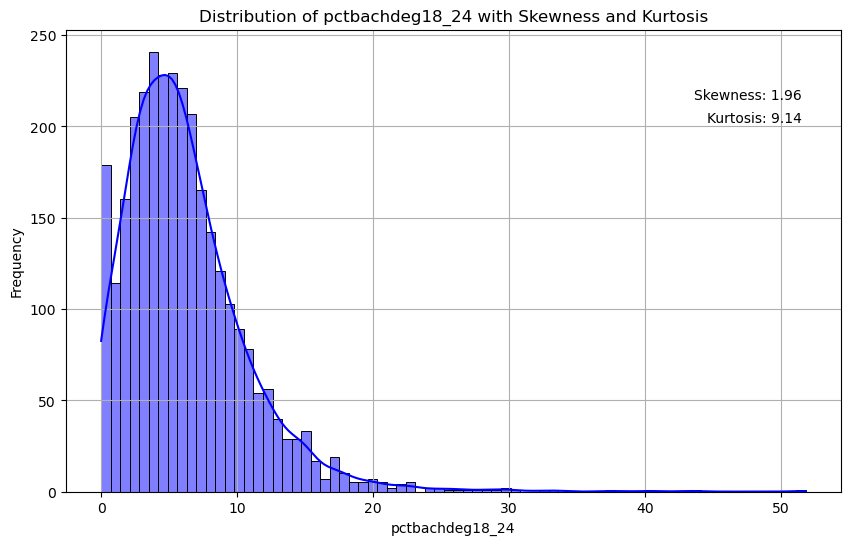

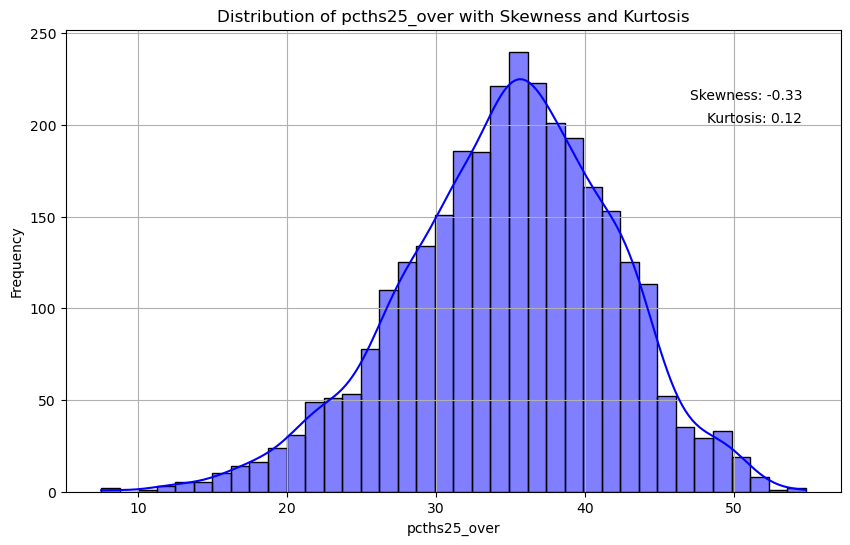

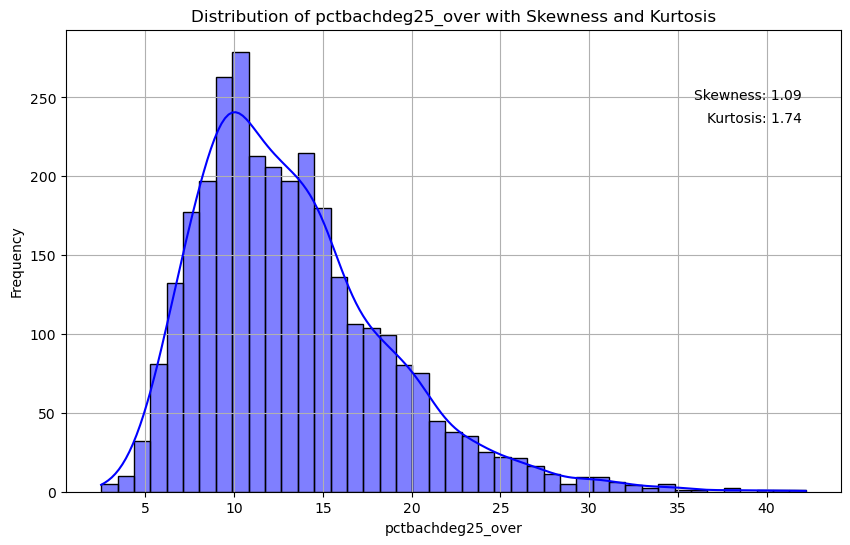

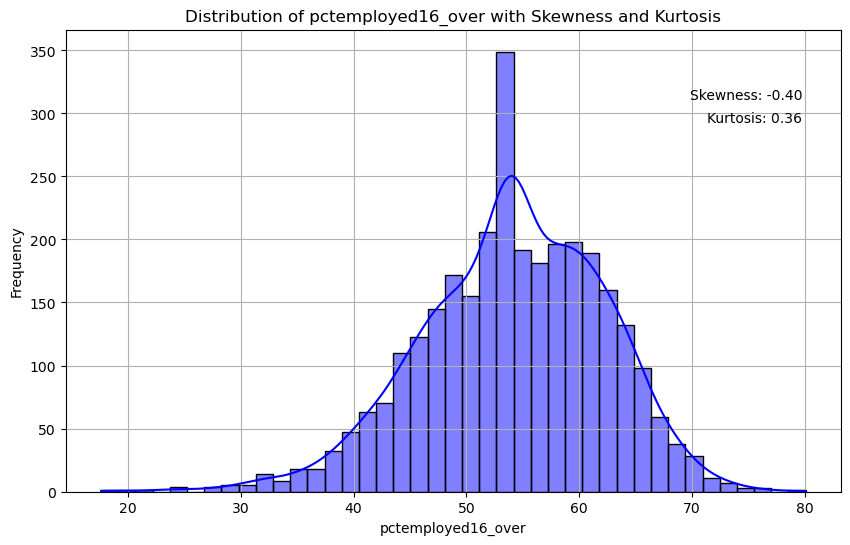

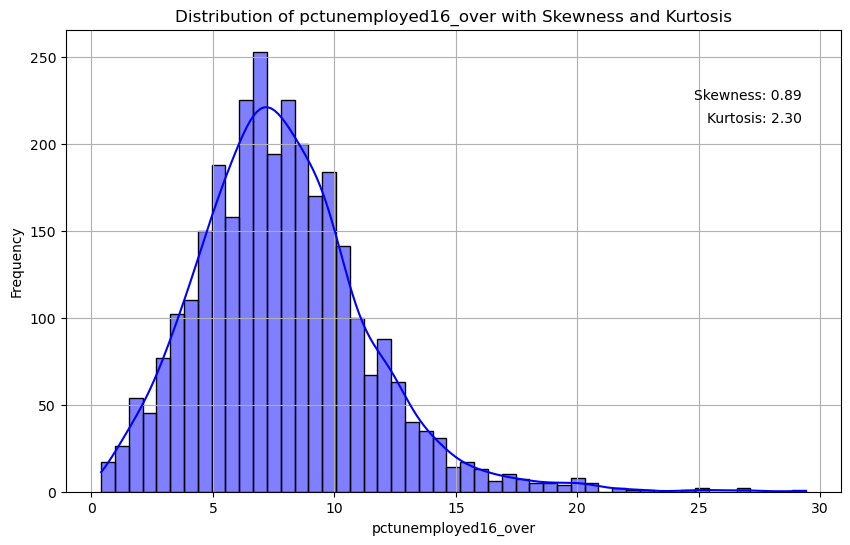

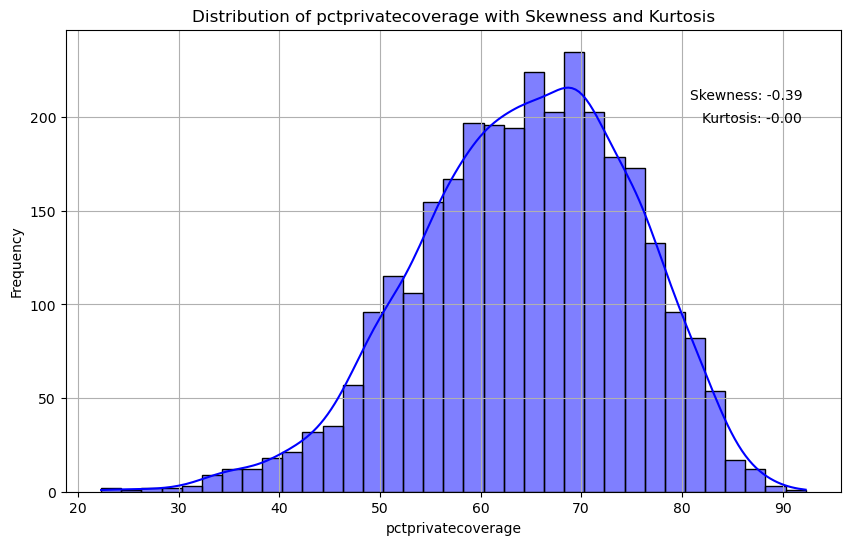

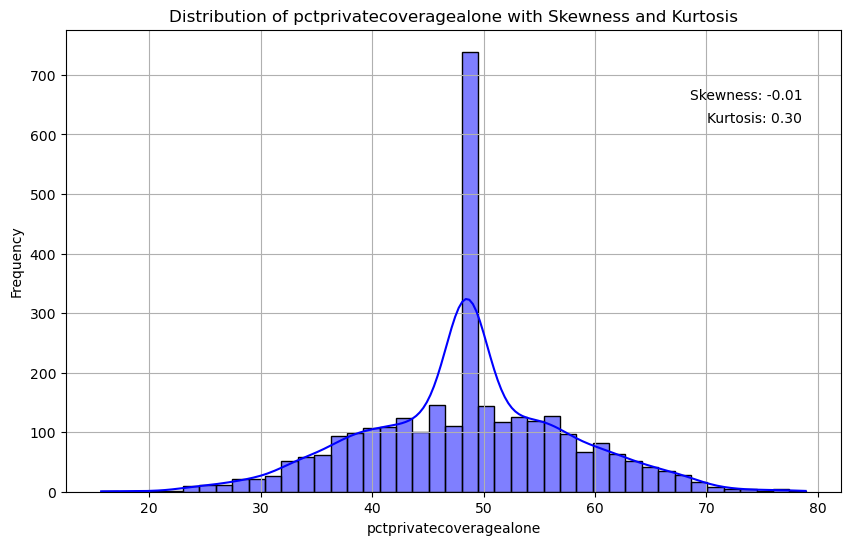

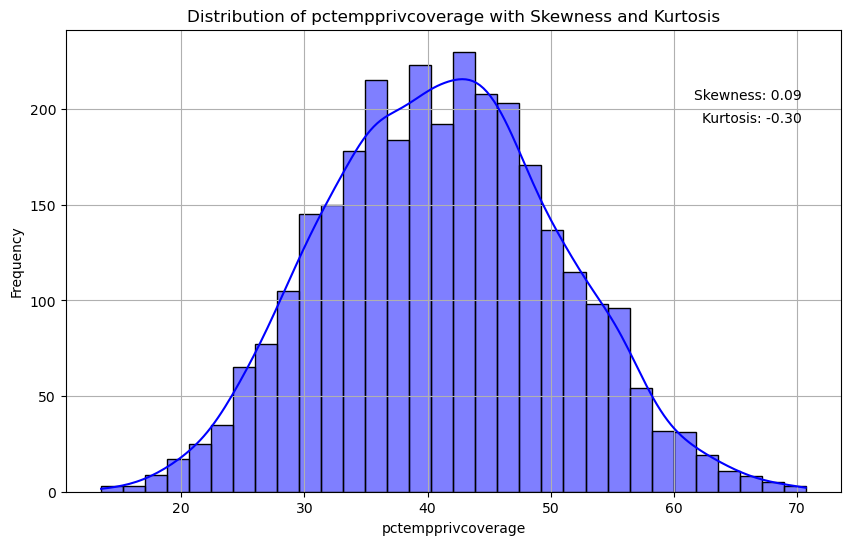

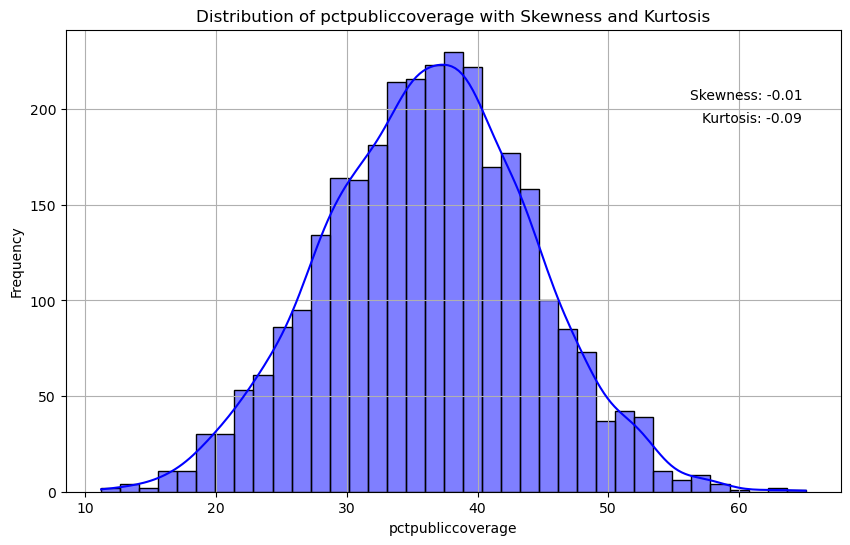

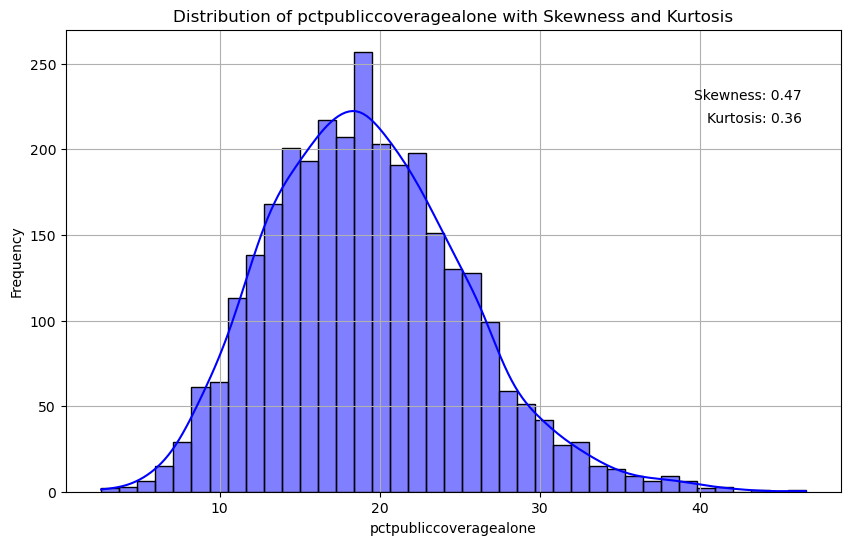

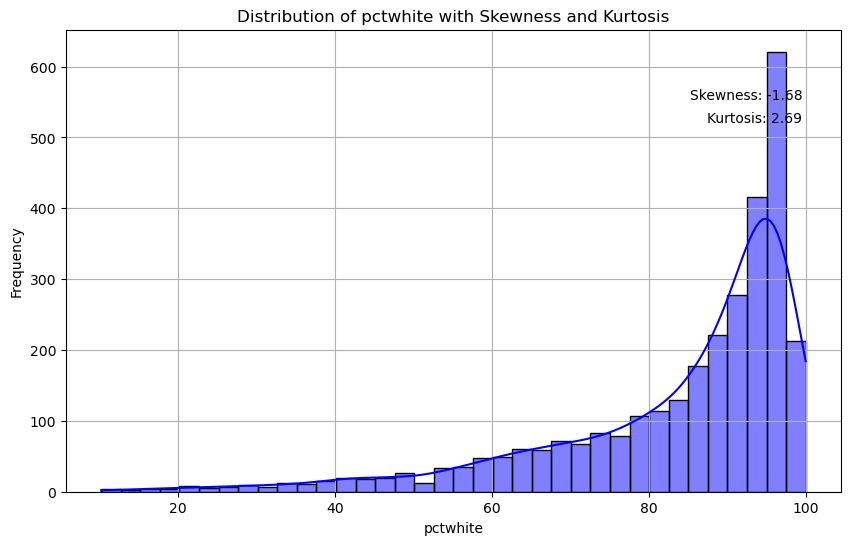

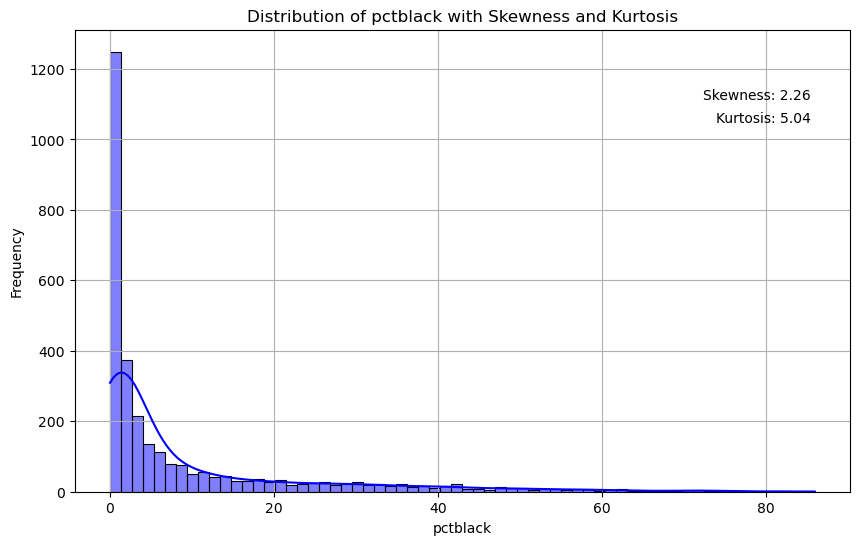

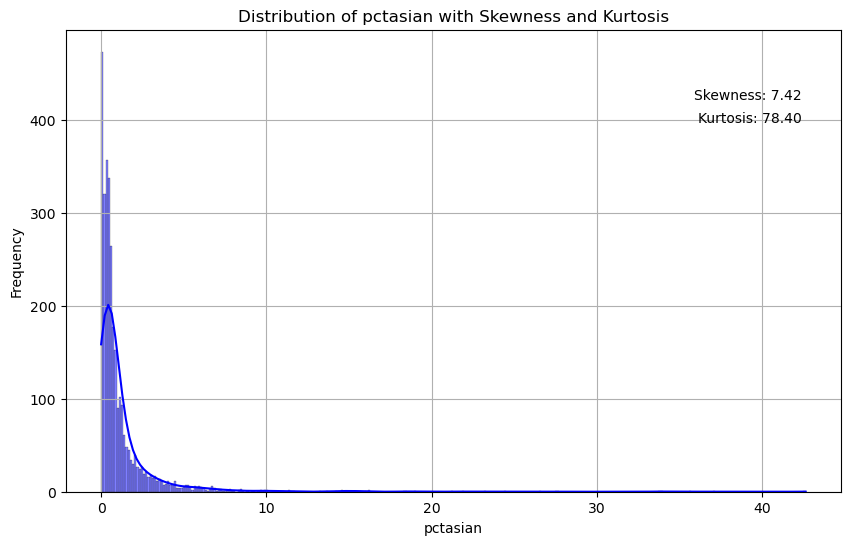

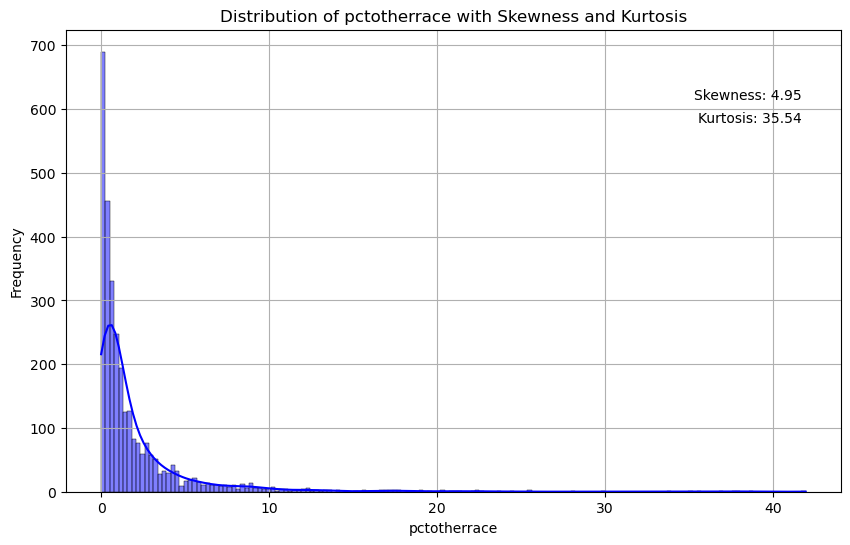

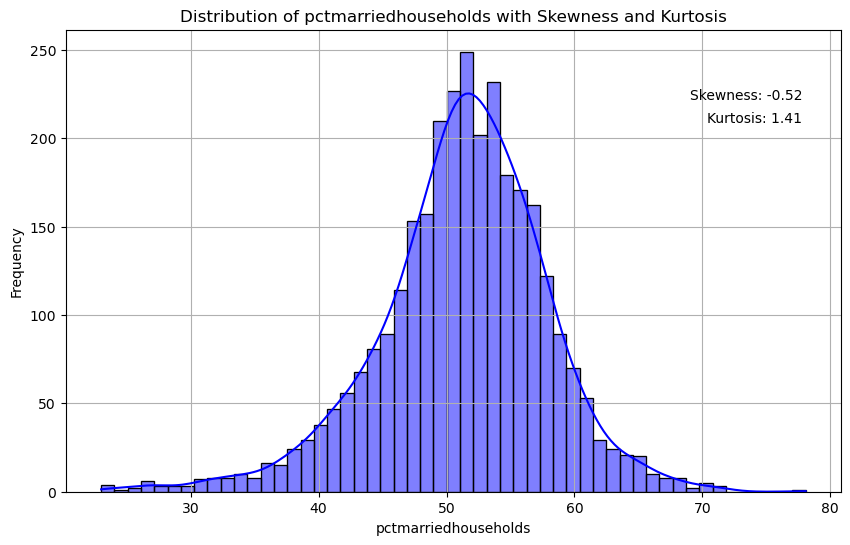

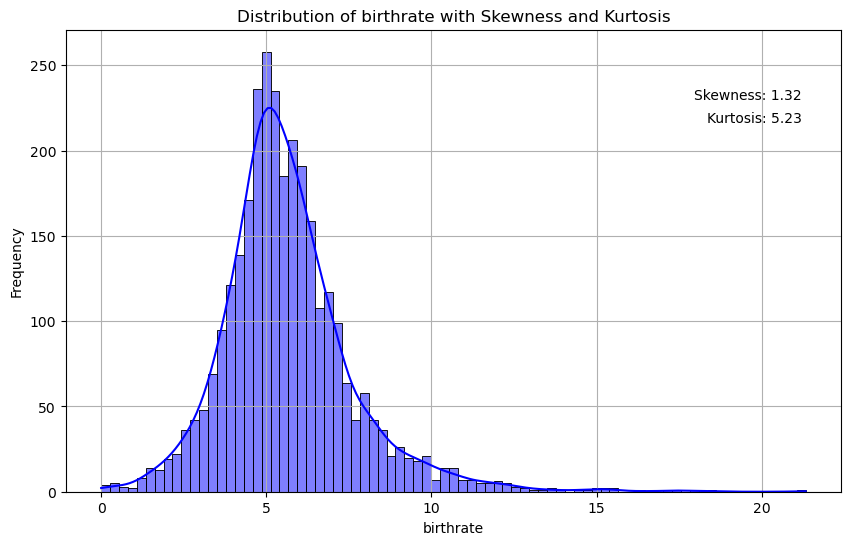

In [24]:
dist_plot(df)

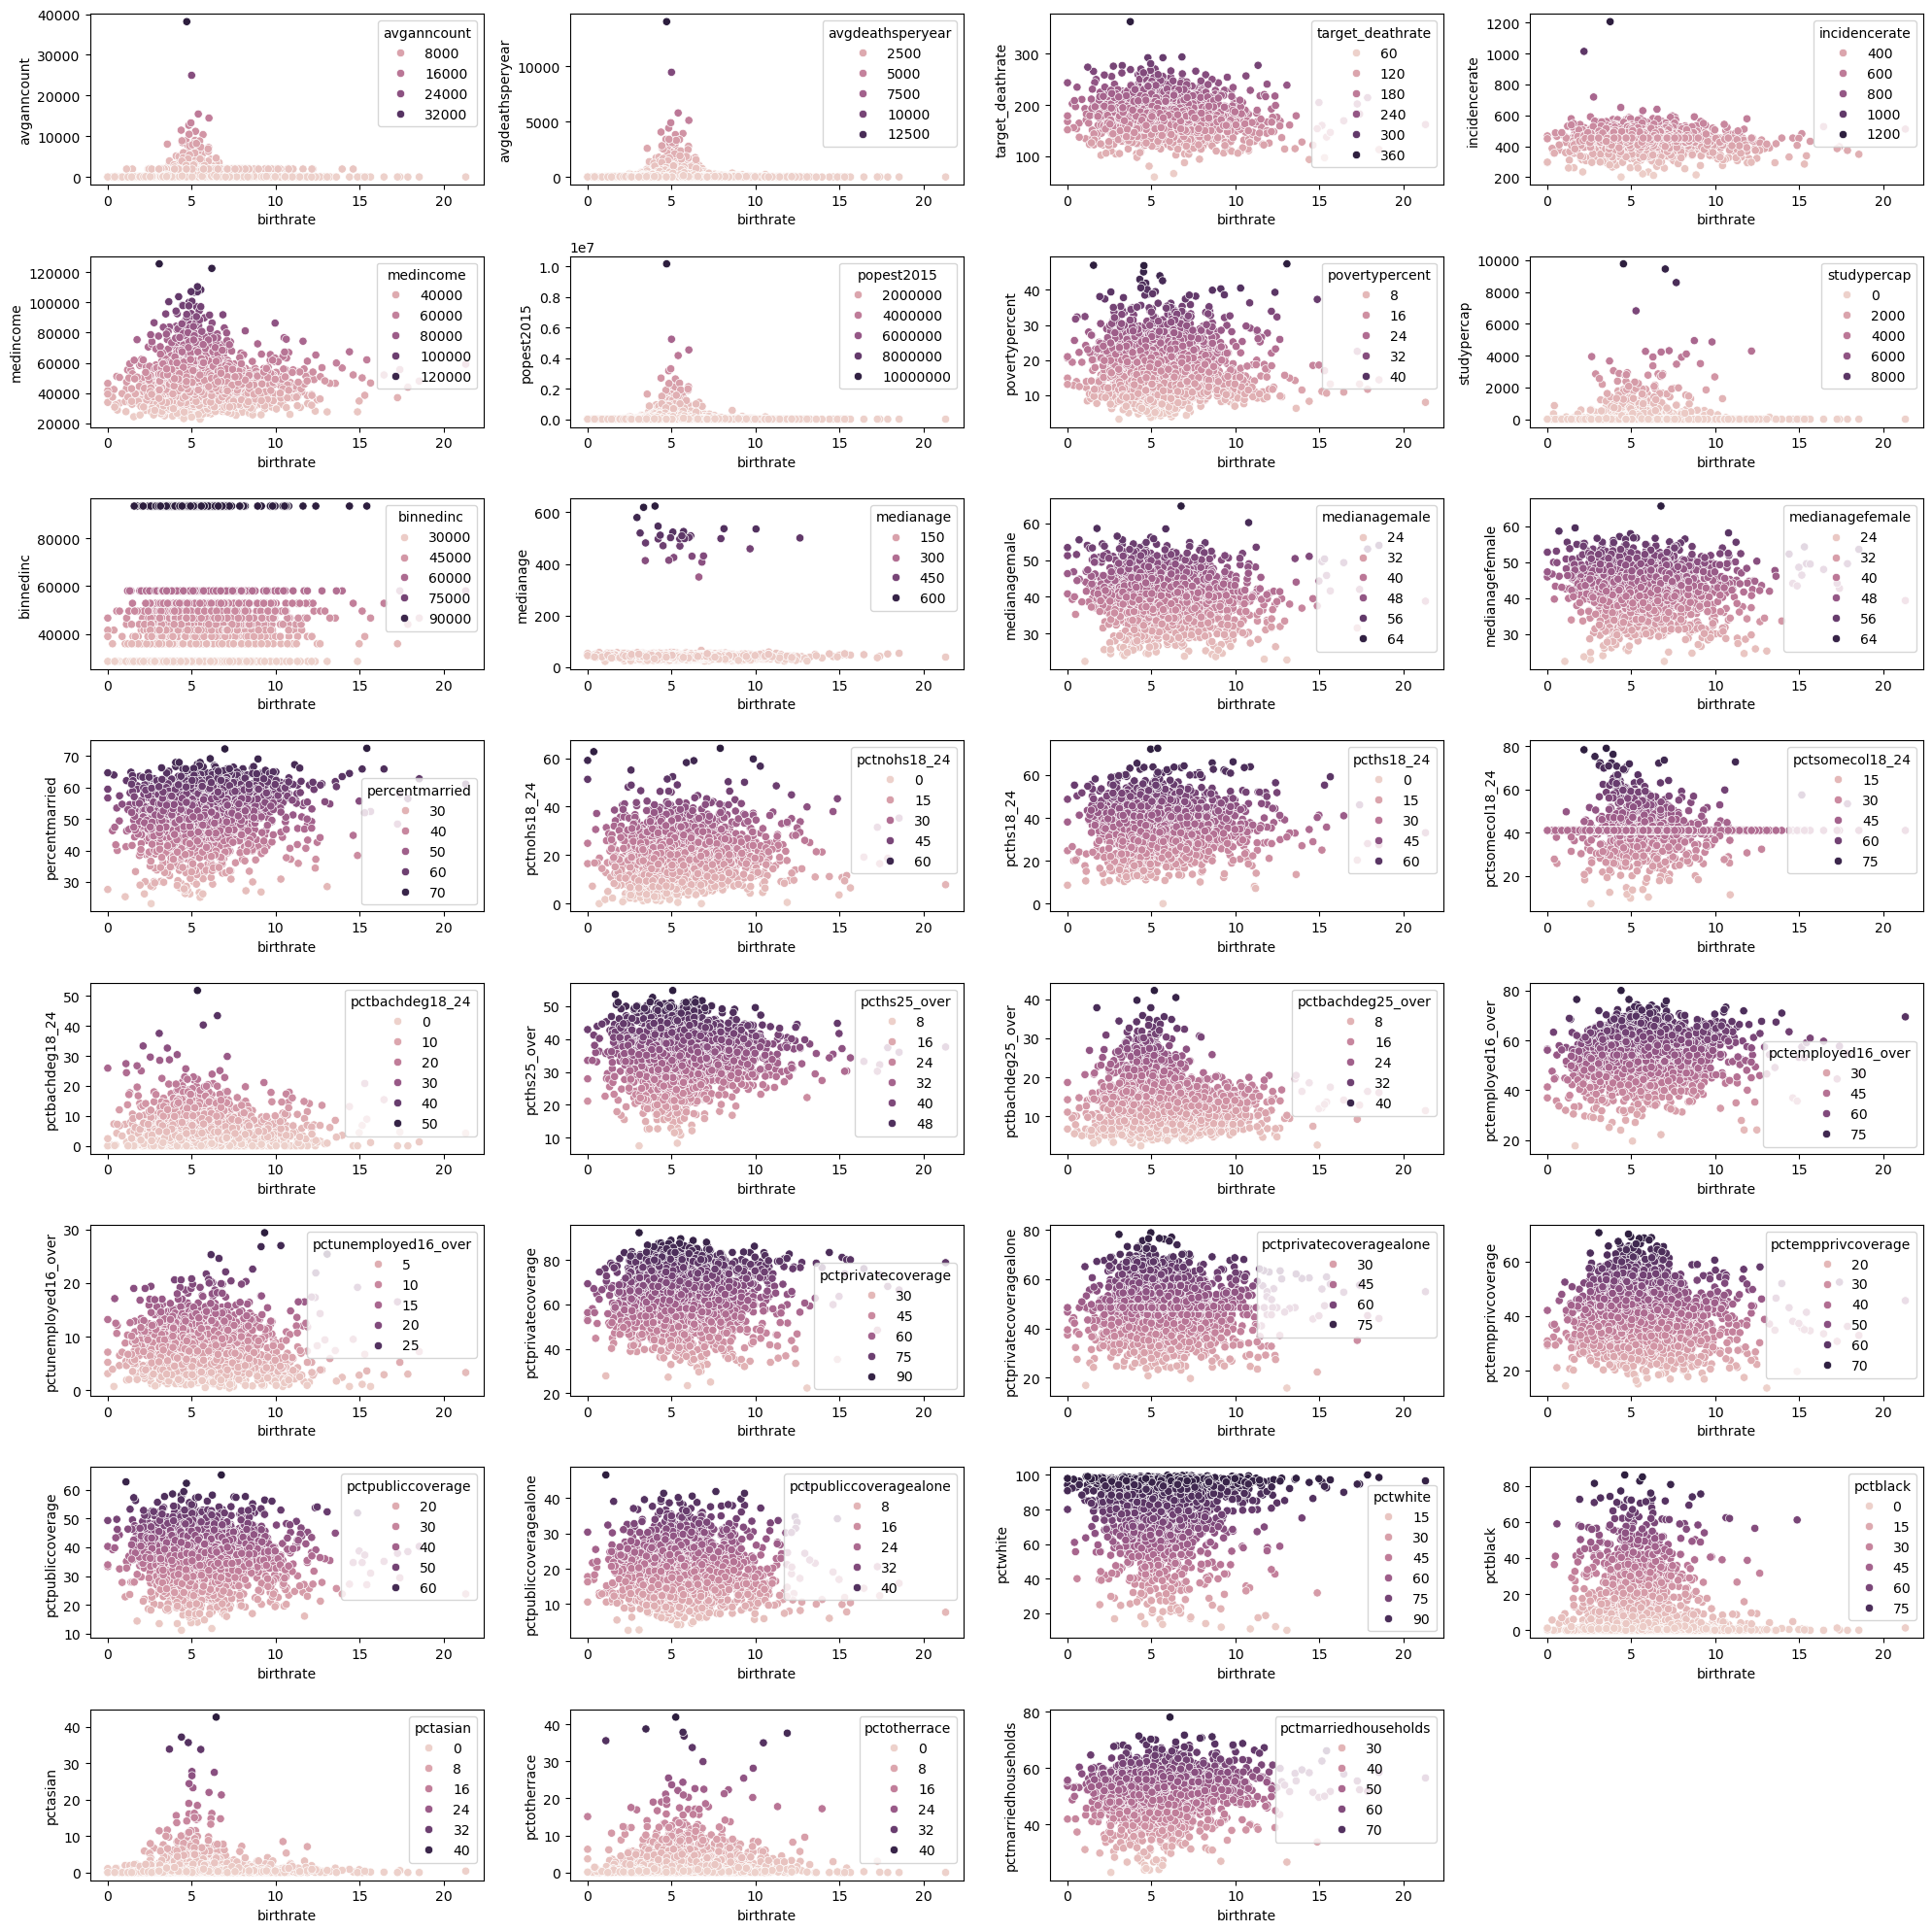

In [38]:
scatter_plot(df, df.columns, "birthrate")

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_3726/1018368851.py:84: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_3726/1018368851.py:84: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_3726/1018368851.py:84: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(x, p, 'k', linewidth=2, color='red', label='Normal Distribution')
/var/folders/

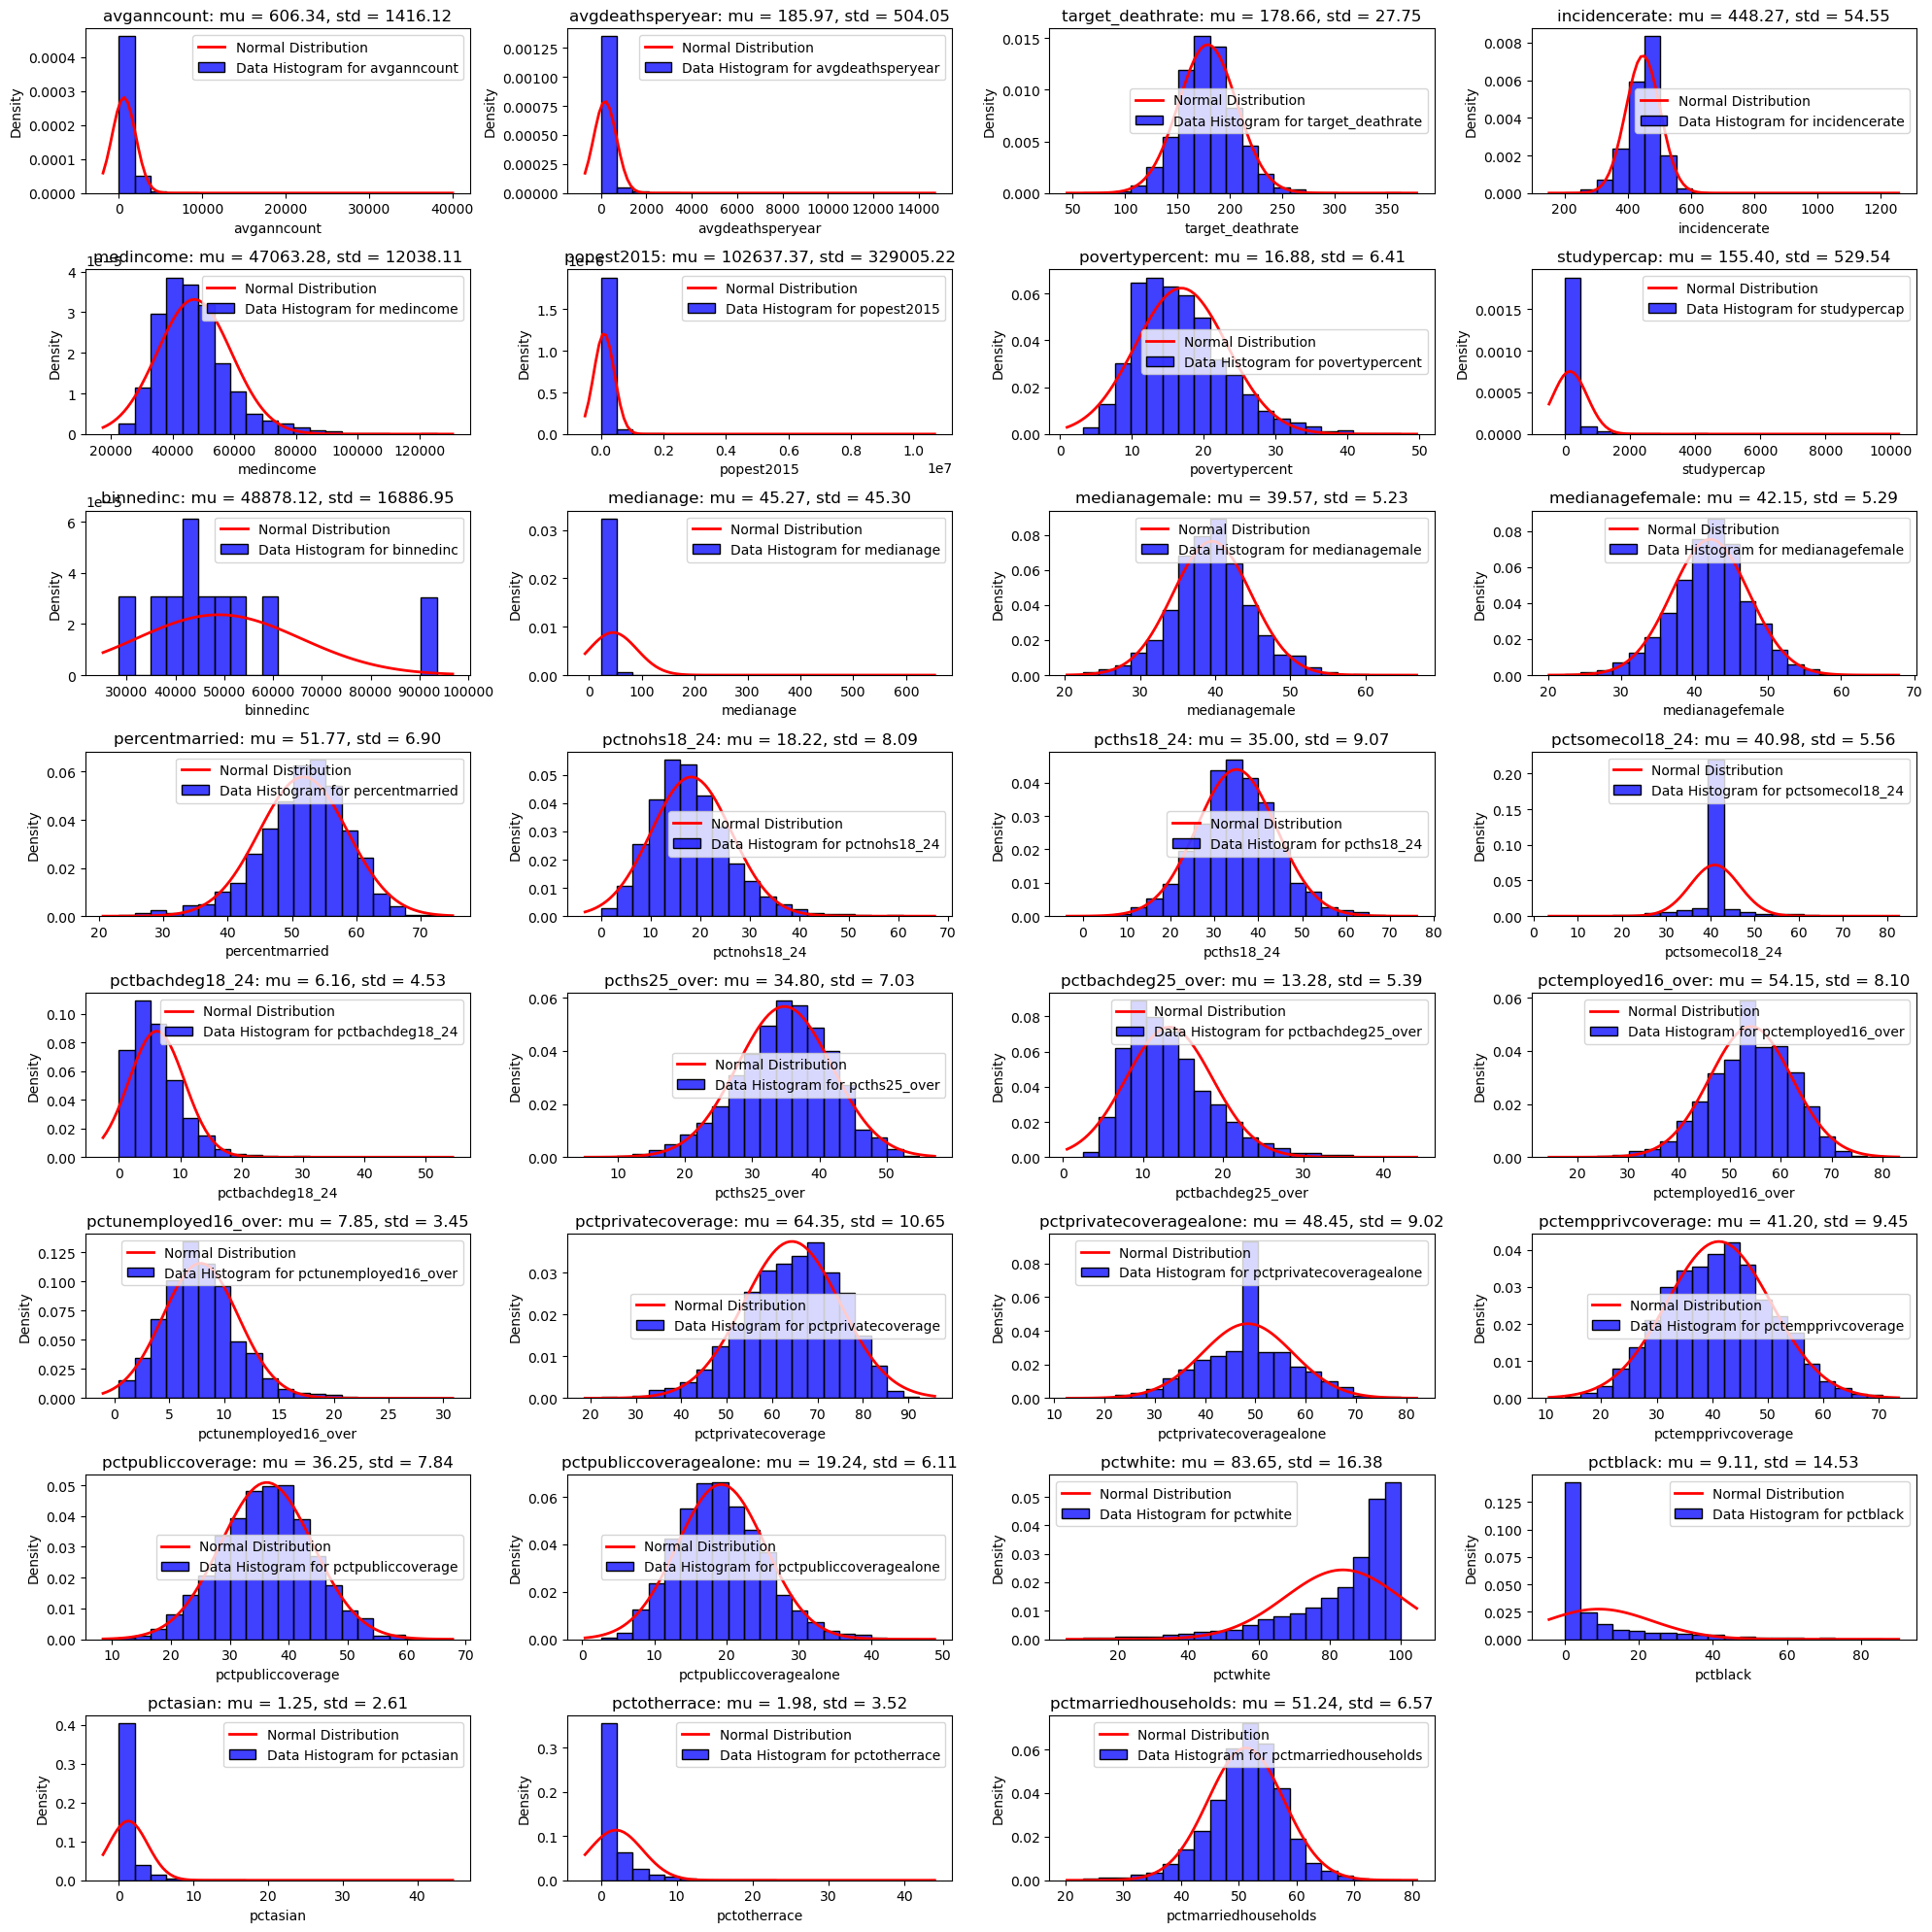

In [41]:
histogram(df, df.columns, "birthrate")

<AxesSubplot:>

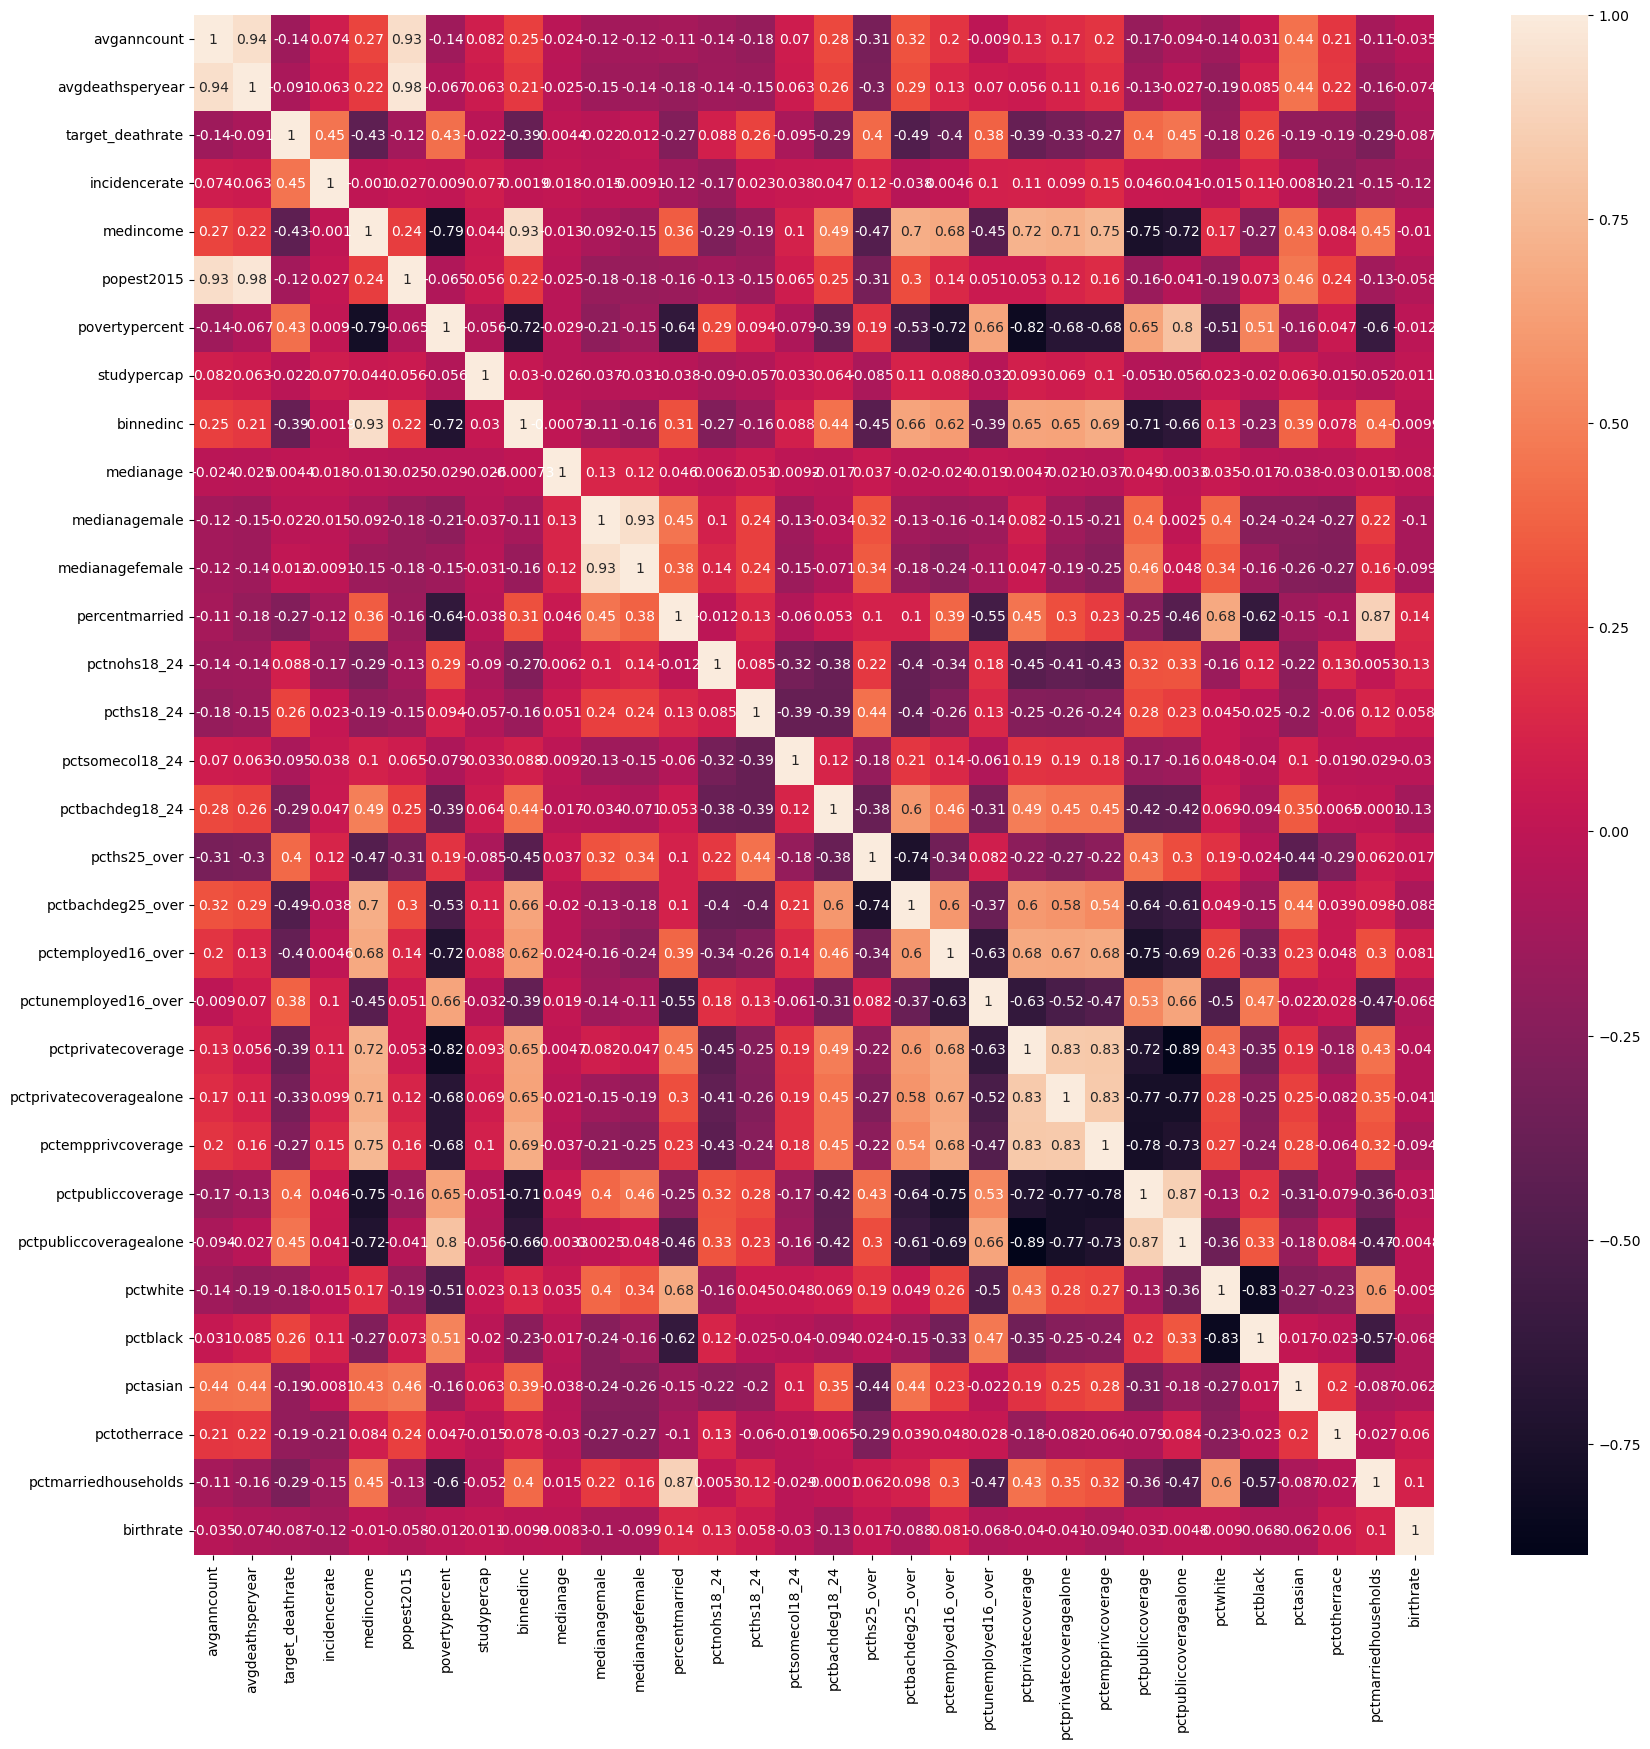

In [42]:
relations = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(data=relations, annot=True)

# Separate Features

In [44]:
X = df.drop("birthrate", axis=1)
y = df["birthrate"]

# PCA Analysis

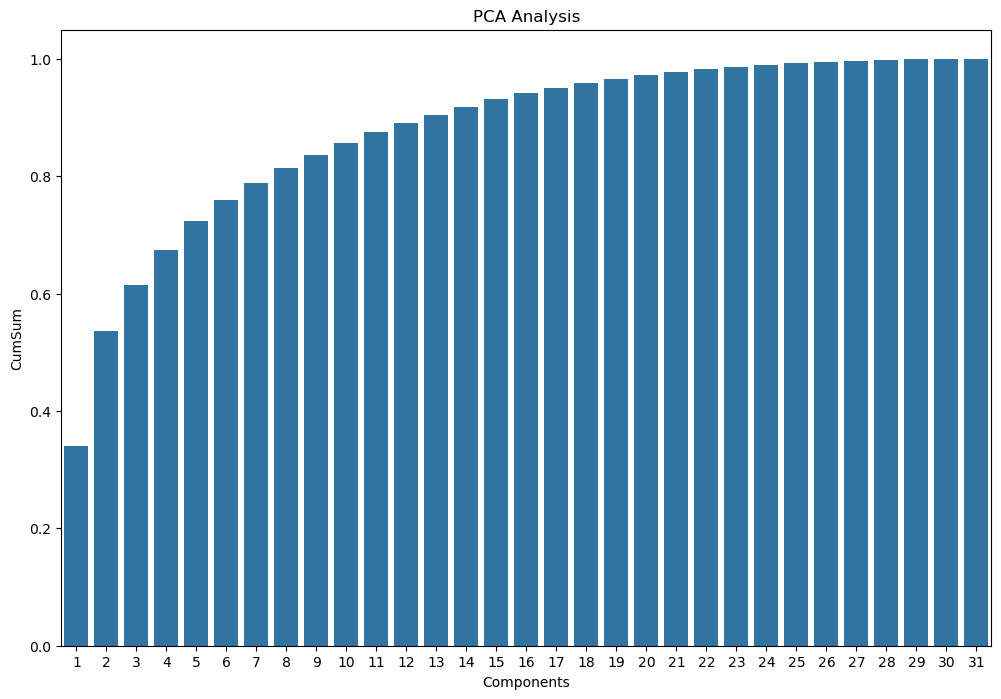

Component    CumSum
0           1  0.339779
1           2  0.536073
2           3  0.614781
3           4  0.674402
4           5  0.723763
5           6  0.760398
6           7  0.788064
7           8  0.813511
8           9  0.836551
9          10  0.856820
10         11  0.875296
11         12  0.891383
12         13  0.905421
13         14  0.918874
14         15  0.931239
15         16  0.941729
16         17  0.950795
17         18  0.958827
18         19  0.966359
19         20  0.973249
20         21  0.978362
21         22  0.982661
22         23  0.986803
23         24  0.990151
24         25  0.993009
25         26  0.995143
26         27  0.996952
27         28  0.998525
28         29  0.999254
29         30  0.999789
30         31  1.000000

In [65]:
pca_analysis(X)

In [50]:
MAE = make_scorer(score_func=mean_absolute_error, greater_is_better =False)
MSE = make_scorer(score_func=mean_squared_error, greater_is_better=False)
R2 = make_scorer(score_func=r2_score, greater_is_better=True)
EXP_VAR = make_scorer(score_func=explained_variance_score, greater_is_better=True)

# Baseline Model

In [66]:
model_names = ["DUMMY"]
models = get_selected_models(model_names)
test_selected_models(model_names, models, X, y, MSE)

Model   Mean    Var    STD    MAE    MSE  RMSE     R2  Explained Var
0  DUMMY -3.945  0.374  0.612  1.418  3.954  1.41 -0.003         -0.003

In [70]:
model_names = ["LR"]
models = get_selected_models(model_names)
kbest = mutual_info_regression
test_kbest_columns(X, y, models[0], model_names[0], kbest)

Model   K       MAE       MSE      RMSE        R2  Explained Var
0     LR   1  1.368059  3.623161  1.903460  0.032868       0.033318
1     LR   2  1.352024  3.575752  1.890966  0.045523       0.045933
2     LR   3  1.350032  3.552632  1.884843  0.051694       0.052199
3     LR   4  1.337941  3.533229  1.879689  0.056873       0.057311
4     LR   5  1.328155  3.504151  1.871938  0.064635       0.064810
5     LR   6  1.309309  3.481384  1.865847  0.070712       0.070880
6     LR   7  1.309362  3.481311  1.865827  0.070732       0.070901
7     LR   8  1.300581  3.463799  1.861129  0.075406       0.075518
8     LR   9  1.272660  3.366815  1.834888  0.101294       0.101419
9     LR  10  1.275269  3.375901  1.837362  0.098869       0.098999
10    LR  11  1.275858  3.378706  1.838126  0.098120       0.098174
11    LR  12  1.270987  3.362574  1.833732  0.102426       0.102460
12    LR  13  1.261117  3.347594  1.829643  0.106425       0.106432
13    LR  14  1.271031  3.349555  1.830179  0.105902       0.105924
14    LR  15  1.258074  3.329913  1.824805  0.111145       0.111146
15    LR  16  1.257630  3.329124  1.824589  0.111355       0.111356
16    LR  17  1.250208  3.332544  1.825526  0.110442       0.110442
17    LR  18  1.249959  3.332593  1.825539  0.110429       0.110429
18    LR  19  1.237396  3.251942  1.803314  0.131957       0.131963
19    LR  20  1.239543  3.276284  1.810051  0.125460       0.125463
20    LR  21  1.233434  3.264357  1.806753  0.128644       0.128656
21    LR  22  1.227572  3.217471  1.793731  0.141159       0.141172
22    LR  23  1.233144  3.260021  1.805553  0.129801       0.129813
23    LR  24  1.230361  3.216756  1.793532  0.141350       0.141351
24    LR  25  1.230892  3.220656  1.794619  0.140309       0.140310
25    LR  26  1.232669  3.222953  1.795258  0.139696       0.139699
26    LR  27  1.231164  3.215313  1.793129  0.141735       0.141735
27    LR  28  1.230724  3.212815  1.792433  0.142402       0.142402
28    LR  29  1.234538  3.232469  1.797907  0.137155       0.137158
29    LR  30  1.235478  3.239656  1.799905  0.135237       0.135238
30    LR  31  1.235494  3.239574  1.799882  0.135259       0.135260

In [71]:
model_names = ["LR"]
models = get_selected_models(model_names)
kbest = f_regression
test_kbest_columns(X, y, models[0], model_names[0], kbest)

Model   K       MAE       MSE      RMSE        R2  Explained Var
0     LR   1  1.371725  3.719653  1.928640  0.007111       0.007473
1     LR   2  1.356048  3.601516  1.897766  0.038646       0.038862
2     LR   3  1.342377  3.587228  1.893998  0.042459       0.042696
3     LR   4  1.334096  3.570424  1.889557  0.046945       0.047204
4     LR   5  1.302419  3.458904  1.859813  0.076713       0.076824
5     LR   6  1.301563  3.456101  1.859059  0.077461       0.077567
6     LR   7  1.268994  3.358174  1.832532  0.103601       0.103649
7     LR   8  1.271567  3.357441  1.832332  0.103797       0.103861
8     LR   9  1.264044  3.348643  1.829930  0.106145       0.106192
9     LR  10  1.258235  3.349129  1.830062  0.106015       0.106039
10    LR  11  1.262595  3.326105  1.823761  0.112161       0.112202
11    LR  12  1.264239  3.333553  1.825802  0.110173       0.110219
12    LR  13  1.250819  3.275688  1.809886  0.125619       0.125675
13    LR  14  1.251959  3.285930  1.812713  0.122885       0.122947
14    LR  15  1.252865  3.289827  1.813788  0.121845       0.121901
15    LR  16  1.252515  3.302328  1.817231  0.118508       0.118509
16    LR  17  1.252619  3.302196  1.817195  0.118543       0.118544
17    LR  18  1.242710  3.241349  1.800375  0.134785       0.134790
18    LR  19  1.243241  3.250862  1.803015  0.132246       0.132254
19    LR  20  1.238964  3.238626  1.799618  0.135512       0.135520
20    LR  21  1.229686  3.213566  1.792642  0.142201       0.142208
21    LR  22  1.230475  3.210629  1.791823  0.142985       0.142993
22    LR  23  1.230687  3.211186  1.791978  0.142836       0.142845
23    LR  24  1.230748  3.211969  1.792197  0.142627       0.142635
24    LR  25  1.230721  3.211987  1.792202  0.142623       0.142630
25    LR  26  1.230739  3.212543  1.792357  0.142474       0.142483
26    LR  27  1.229661  3.216001  1.793321  0.141551       0.141572
27    LR  28  1.228825  3.210018  1.791652  0.143148       0.143163
28    LR  29  1.230349  3.225798  1.796051  0.138936       0.138936
29    LR  30  1.230143  3.226485  1.796242  0.138753       0.138755
30    LR  31  1.235494  3.239574  1.799882  0.135259       0.135260

In [72]:
model_names = ["LR", "SVR", "KNN"]
models = get_selected_models(model_names)
kbest = SelectKBest(score_func=mutual_info_regression, k=10)
test_selected_models(model_names, models, X, y, MSE, kbest)

Model   Mean    Var    STD    MAE    MSE   RMSE     R2  Explained Var
0    LR -3.595  0.327  0.572  1.326  3.595  1.377  0.088          0.088
1   SVR -3.574  0.324  0.569  1.310  3.616  1.379  0.083          0.089
2   KNN -4.186  0.365  0.604  1.435  4.237  1.435 -0.075         -0.074

In [74]:
model_names = ["XGB", "GBR", "RFR", "LASSO", "RIDGE"]
models = get_selected_models(model_names)
test_selected_models(model_names, models, X, y, MSE, kbest)

Model   Mean    Var    STD    MAE    MSE   RMSE     R2  Explained Var
4  RIDGE -3.724  0.309  0.556  1.364  3.731  1.390  0.054          0.054
1    GBR -3.836  0.324  0.569  1.388  3.901  1.405  0.011          0.011
3  LASSO -3.945  0.374  0.612  1.418  3.954  1.410 -0.003         -0.003
2    RFR -3.978  0.268  0.518  1.408  4.019  1.416 -0.019         -0.019
0    XGB -4.449  0.433  0.658  1.446  4.397  1.448 -0.115         -0.115

In [75]:
params = {
  'RIDGE': {
        'model__alpha': [0.01, 0.1, 1, 10, 100],
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'LASSO': {
        'model__alpha': [0.01, 0.1, 1, 10, 100],
        'model__max_iter': [1000, 5000, 10000]
    },
  
    'DTR': {
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 10, 20],
        'model__min_samples_leaf': [1, 5, 10]
    },
    'RFR': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 10, 20],
        'model__min_samples_leaf': [1, 5, 10]
    },
    'GBR': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 4, 6],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'SVR': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto']
    },
    'KNN': {
        'model__n_neighbors': [3, 5, 10, 15],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size': [10, 30, 50],
        'model__p': [1, 2]
    },
    'XGB': {
        'model__n_estimators': [100, 150, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0],
        'model__gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node
        'model__reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights
        'model__reg_lambda': [1, 1.5, 2.0]  # L2 regularization term on weights
    }
}

In [76]:
model_names = ["XGB", "GBR", "RFR","LASSO", "RIDGE", "KNN", "SVR"]
new_models = get_selected_models(model_names)
optimization_search(model_names, new_models, X, y, RandomizedSearchCV, params, MSE, kbest)

The Best Param: {'model__subsample': 0.6, 'model__reg_lambda': 1.5, 'model__reg_alpha': 0.5, 'model__n_estimators': 150, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__gamma': 0.2, 'model__colsample_bytree': 0.6} for Model: XGB
The Best Param: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 7, 'model__learning_rate': 0.01} for Model: GBR
The Best Param: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 10, 'model__max_depth': None} for Model: RFR
